In [3]:
import pandas as pd
import numpy as np
import load_utils as lu
import metrics_utils as mu
import sys
import os
import datetime
from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio filesrom IPython.display import Audio
from sklearn.model_selection import KFold


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
#  mel 64*64 
train_basic_path = "./features/features-train-no-uk-mel-v6-16khz.csv"
val_basic_path = "./features/features-val-no-uk-mel-v6-16khz.csv"
test_basic_path = "./features/features-test-no-uk-mel-v6-16khz.csv"

#  mel 64*64 esd only
# train_basic_path = "./features/features-train-no-uk-mel-v6-esd-16khz.csv"
# val_basic_path = "./features/features-val-no-uk-mel-v6-esd-16khz.csv"
# test_basic_path = "./features/features-test-no-uk-mel-v6-esd-16khz.csv"


In [5]:
encoder = OneHotEncoder()

In [6]:
train_basic, val_basic, test_basic, test_basic_decoded = lu.load_encode([train_basic_path, val_basic_path, test_basic_path], encoder)

./features/features-train-no-uk-mel-v6-16khz.csv
(29567, 64, 64) (29567, 7)
./features/features-val-no-uk-mel-v6-16khz.csv
(3696, 64, 64) (3696, 7)
./features/features-test-no-uk-mel-v6-16khz.csv
(3696, 64, 64) (3696, 7)


In [7]:
# mfcc 64*64. New uk only data.
train_uk_path = "./features/features-train-uk-new-mel-v4.csv"
val_uk_path = "./features/features-val-uk-new-mel-v4.csv"
test_uk_path = "./features/features-test-uk-new-mel-v4.csv"


train_uk, val_uk, test_uk, test_uk_decoded = lu.load_encode([train_uk_path, val_uk_path, test_uk_path], encoder)

./features/features-train-uk-new-mel-v4.csv
(77, 64, 64) (77, 7)
./features/features-val-uk-new-mel-v4.csv
(34, 64, 64) (34, 7)
./features/features-test-uk-new-mel-v4.csv
(41, 64, 64) (41, 7)


In [8]:
# with open("encoder_categories.txt", "w") as txt_file:
#     for category in encoder.categories_[0]:
#         txt_file.write(f"{category}\n")

In [9]:
# train_basic_t = train_basic[0].transpose((0, 2, 1))
# val_basic_t = val_basic[0].transpose((0, 2, 1))
# test_basic_t = test_basic[0].transpose((0, 2, 1))
# train_basic_t = train_basic_t[:, :, :48]
# val_basic_t = val_basic_t[:, :, :48]
# test_basic_t = test_basic_t[:, :, :48]
# test_basic_t.shape

## Modeling


### Imports


In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Reshape, TimeDistributed, Activation, Input, GRU, Dense, LSTM, Conv2D, Conv3D, Conv1D, MaxPooling2D, MaxPooling1D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

In [12]:
from tensorflow.keras.utils import plot_model
# plot_model(model, "mini_resnet.png", show_shapes=True)

### Functions

In [13]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

In [14]:
def print_report_v3(history, metric, val_metric):
    epochs = history.epoch
    fig, ax = plt.subplots(1, 2)

    train_acc = history.history[metric]
    train_loss = history.history['loss']
    test_acc = history.history[val_metric]
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()


def get_metrics_v2(model, test_data, tag, steps=20):

    # Model Evaluation
    err, acc = model.evaluate_generator(generator=test_data, steps=steps)
    print(err, acc)
    test_data.reset()

    y_pred = model.predict_generator(test_data, verbose=1)
    # encoded prediction e.g 0 1 2 3
    y_pred_indices = np.argmax(y_pred, axis=1)
    labels = (test_data.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    y_pred_decoded = [labels[k] for k in y_pred_indices]
    y_true_decoded = [labels[k] for k in test_data.labels]
    print(len(y_pred_decoded), len(y_true_decoded))

    metrics_map = {'model': tag, 'recall': 0,
                   'precision': 0, 'accuracy': 0, 'f1': 0}

    metrics_map['recall'] = recall_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded, average='micro')
    metrics_map['precision'] = precision_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded, average='micro')
    metrics_map['accuracy'] = accuracy_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded)
    metrics_map['f1'] = f1_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded, average='micro')

    results = pd.DataFrame(metrics_map, index=[0])

    if (os.path.exists('training_results.csv')):
        saved_metrics = pd.read_csv('training_results.csv')

        results = results.append(saved_metrics)

    results.to_csv('training_results.csv', index=False)

    return [y_pred_decoded, y_true_decoded]

In [15]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()


def print_confusion_matrix_v2(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    # cm = pd.DataFrame(cm, index=[i for i in features_uk_test_df.labels.unique()], columns=[
    #     i for i in features_uk_test_df.labels.unique()])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

### Model

### functions

In [16]:
class GRULayer(layers.Layer):
	def __init__(self, units):
		super(GRULayer, self).__init__()
		self.gru = layers.GRU(units)

	def call(self, inputs):
		channels = []
		num_channels = inputs.shape[-1]
		for channel_index in range(num_channels):
			channels.append(inputs[:, :, :, channel_index])

		gru_outputs = []
		for i in range(len(channels)):
			input_var = channels[i]
			gru_output = self.gru(input_var)  # Use the predefined GRU layer
			gru_outputs.append(gru_output)

		return layers.Concatenate()(gru_outputs)

In [17]:
class LSTMLayer(layers.Layer):
	def __init__(self, units, input_shape, seq=False):
		super(LSTMLayer, self).__init__()
		self.lstm = layers.LSTM(units, input_shape=input_shape, return_sequences=seq)

	def call(self, inputs):
		channels = []
		num_channels = inputs.shape[-1]
		for channel_index in range(num_channels):
			channels.append(inputs[:, :, :, channel_index])

		outputs = []
		for i in range(len(channels)):
			input_var = channels[i]
			output = self.lstm(input_var)  # Use the predefined GRU layer
			outputs.append(output)

		return layers.Add()(outputs)

In [18]:
class BiLSTMLayer(layers.Layer):
	def __init__(self, units, input_shape, seq=False):
		super(BiLSTMLayer, self).__init__()
		self.lstm = layers.Bidirectional(LSTM(units, input_shape=input_shape, return_sequences=seq))

	def call(self, inputs):
		channels = []
		num_channels = inputs.shape[-1]
		for channel_index in range(num_channels):
			channels.append(inputs[:, :, :, channel_index])

		outputs = []
		for i in range(len(channels)):
			input_var = channels[i]
			output = self.lstm(input_var)  # Use the predefined GRU layer
			outputs.append(output)

		return layers.Add()(outputs)

In [19]:
def residual_block(x, kernel, filters, k, strides=1):
    shortcut = x
    if strides != 1:  # Downsampling
        shortcut = tf.keras.layers.Conv2D(
            filters * k, 1, strides=strides, activation=None, kernel_initializer=initializers.HeUniform(seed=1))(shortcut)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(
        filters * k, kernel_size=kernel, padding="same", strides=strides, activation=None, kernel_initializer=initializers.HeUniform(seed=1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(
        filters * k, kernel_size=kernel, padding="same", activation=None, kernel_initializer=initializers.HeUniform(seed=1))(x)
    x = tf.keras.layers.add([x, shortcut])
    return x

### models


In [20]:
train_basic[0].shape

(29567, 64, 64)

combine cnn_lstm + wide resnet

In [21]:
# def get_model(name = None):
#     input_shape = (64, 64, 1)
#     emotions_number = train_basic[1].shape[1]
#     k = 1

#     inputs = tf.keras.layers.Input(
#         shape=input_shape, name='spec')

#     # # wide resnet
#     right_x = tf.keras.layers.Conv2D(16, 3, padding="same", activation=None,
#                                     kernel_initializer=initializers.HeUniform(seed=1))(inputs)
#     right_x = tf.keras.layers.MaxPooling2D(2)(right_x)
#     right_x = tf.keras.layers.Activation("relu")(right_x)

#     right_x = residual_block(right_x, kernel=3, filters=16, k=1, strides=1)  
#     right_x = residual_block(right_x, kernel=3, filters=16, k=k, strides=2)  
#     # x = residual_block(x, kernel=3, filters=32, k=k, strides=2)  

#     # right_x = tf.keras.layers.Dropout(0.3)(right_x)
#     # right_x = tf.keras.layers.GlobalAveragePooling2D()(right_x)

#     # regular cnn
#     # left_x = BatchNormalization()(inputs)
#     # left_x = Conv1D(filters=16, kernel_size=7, strides=1, padding="same",
#     #                 activation=None, kernel_initializer=initializers.HeUniform(seed=1))(left_x)
#     # left_x = MaxPooling2D(pool_size=2)(left_x)
#     # left_x = Activation("relu")(left_x)

#     # left_x = BatchNormalization()(left_x)
#     # left_x = Conv1D(filters=32, kernel_size=5, strides=1, padding="same",
#     #                 activation=None, kernel_initializer=initializers.HeUniform(seed=1))(left_x)
#     # left_x = MaxPooling2D(pool_size=2)(left_x)
#     # left_x = Activation("relu")(left_x)
    
#     # left_x = BatchNormalization()(left_x)
#     # left_x = Conv1D(filters=64, kernel_size=5, strides=1, padding="same",
#     #                 activation=None, kernel_initializer=initializers.HeUniform(seed=1))(left_x)
#     # left_x = MaxPooling2D(pool_size=2)(left_x)
#     # left_x = Activation("relu", name='last_cnn_segment')(left_x)
#     # left_x = layers.Masking(mask_value=0.0)(left_x)

#     # print(left_x.shape, right_x.shape)

#     # merge = tf.keras.layers.concatenate([left_x, right_x])
#     # merge = Flatten()(merge)

#     # rnn_layers = LSTMLayer(96, (16, 16), False)
#     rnn_layers = layers.TimeDistributed(GRU(128, return_sequences=True))
#     merge = rnn_layers(right_x)

#     merge = GlobalAveragePooling2D()(merge) # flatten -> gap
#     # merge = Flatten()(merge) # flatten -> gap
#     outputs = tf.keras.layers.Dense(emotions_number, activation="softmax")(merge)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     if name:
#         model._name = name
    
#     return model

In [ ]:
def get_model(name = None):
    input_shape = (64, 64, 1)
    emotions_number = train_basic[1].shape[1]
    k = 1

    inputs = tf.keras.layers.Input(
        shape=input_shape, name='spec')

    right_x = tf.keras.layers.Conv2D(16, 3, padding="same", activation=None,
                                    kernel_initializer=initializers.HeUniform(seed=1))(inputs)
    right_x = tf.keras.layers.MaxPooling2D(2)(right_x)
    right_x = tf.keras.layers.Activation("relu")(right_x)

    right_x = residual_block(right_x, kernel=3, filters=16, k=1, strides=1)  
    right_x = residual_block(right_x, kernel=3, filters=16, k=k, strides=2)  

    rnn_layers = layers.TimeDistributed(GRU(128, return_sequences=True))
    merge = rnn_layers(right_x)

    merge = GlobalAveragePooling2D()(merge) # flatten -> gap
    outputs = tf.keras.layers.Dense(emotions_number, activation="softmax")(merge)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    if name:
        model._name = name
    
    return model


print(get_model().summary())

In [90]:
def get_model_v4(name = None):
    # input_shape = (64, 64, 1)
    # emotions_number = train_basic[1].shape[1]
    # k = 1

    # inputs = tf.keras.layers.Input(
    #     shape=input_shape, name='spec')

    # right_x = tf.keras.layers.Conv2D(16, 5, padding="same", activation=None,
    #                                 kernel_initializer=initializers.HeUniform(seed=1))(inputs)
    # right_x = tf.keras.layers.MaxPooling2D(3)(right_x)
    # right_x = tf.keras.layers.Activation("relu")(right_x)

    # # right_x = residual_block(right_x, kernel=3, filters=16, k=1, strides=1)  
    # # right_x = residual_block(right_x, kernel=3, filters=16, k=k, strides=2)  

    # rnn_layers = layers.TimeDistributed(GRU(128, return_sequences=True))
    # merge = rnn_layers(right_x)

    # merge = GlobalAveragePooling2D()(merge) # flatten -> gap
    # outputs = tf.keras.layers.Dense(emotions_number, activation="softmax")(merge)

    # model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # if name:
    #     model._name = name
    
    # return model
    
    input_shape = (64, 64, 1)
    emotions_number = train_basic[1].shape[1]
    k = 1
    
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(Conv2D(16, 5, padding="same", activation='relu', kernel_initializer=initializers.HeUniform(seed=1)))
    model.add(TimeDistributed(GRU(128, return_sequences=False)))
    # model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(64, activation="relu", kernel_initializer=initializers.HeUniform(seed=1)))
    model.add(Dense(emotions_number, activation="softmax"))
    if name:
        model._name = name
    
    return model


print(get_model_v4().summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 16)        416       
                                                                 
 time_distributed_14 (TimeDi  (None, 64, 128)          56064     
 stributed)                                                      
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                524352    
                                                                 
 dense_15 (Dense)            (None, 7)                 455       
                                                                 
Total params: 581,287
Trainable params: 581,287
Non-trainable params: 0
________________________________________________

In [62]:
# a = np.array(([[[11,11],[12,12]],[[21,21],[22,22]]]))
# print(a.shape)
# # print(a.flatten())
# # print(a[0])
# print(a)
# print(a.reshape(4, 2))

(2, 2, 2)
[[[11 11]
  [12 12]]

 [[21 21]
  [22 22]]]
[[11 11]
 [12 12]
 [21 21]
 [22 22]]


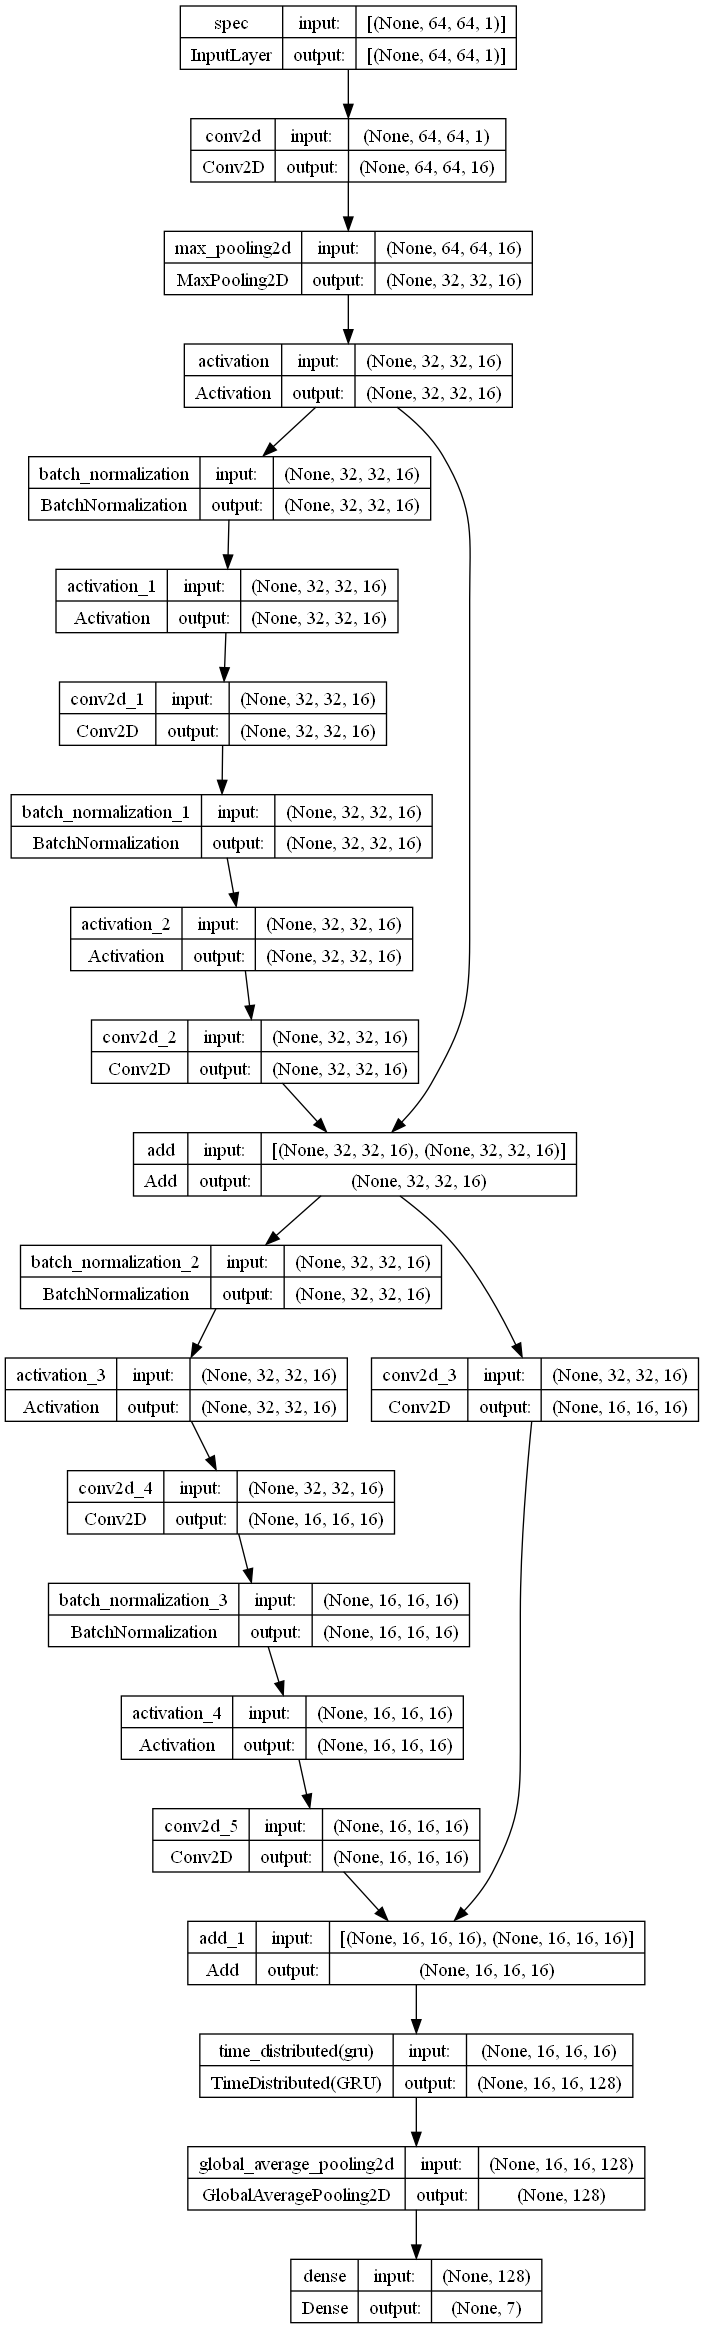

In [20]:
plot_model(get_model(), "cnn_gru.png", show_shapes=True)


### Train

#### prep

In [91]:
train_size=len(train_basic[0])
batch_size_=128
initial_learning_rate = 0.002
final_learning_rate = 0.0001
epochsA = 100
epochsS = 150

In [92]:
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochsA)
steps_per_epoch = int(train_size/batch_size_)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


learning_rate_decay_factor = (0.001 / 0.01)**(1/epochsS)
steps_per_epoch = int(train_size/batch_size_)
lr_schedule_sgd = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

In [93]:
use_sgd = False
if (use_sgd):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule_sgd)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



#### actual train

In [94]:
tf.random.set_seed(1)

In [95]:
np.isinf(test_basic[0]).sum()

0

In [96]:
all_features = np.vstack([train_basic[0], val_basic[0], test_basic[0]])


x_train_scaled = 2.*(train_basic[0] - np.min(all_features))/np.ptp(all_features)-1
x_val_scaled = 2.*(val_basic[0] - np.min(all_features))/np.ptp(all_features)-1
x_test_scaled = 2.*(test_basic[0] - np.min(all_features))/np.ptp(all_features)-1

In [97]:
# one way to deal with overfitting. does not make predictions better
# x_train_scaled = x_train_scaled[:, :44, :]
# x_val_scaled = x_val_scaled[:, :44, :]
# x_test_scaled = x_test_scaled[:, :44, :]

In [100]:
model_name = "cnn-gru-v4-seq-no-scale-16khz"
model = get_model_v4(model_name)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [101]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
if (use_sgd):
    epochs = epochsS
else:
    epochs = epochsA

history = model.fit(train_basic[0], train_basic[1],
                    epochs=epochs,
                    batch_size=batch_size_,
                    validation_data=(val_basic[0], val_basic[1]),
                    callbacks=[early_stopping, tensorboard_callback])

Epoch 1/100
231/231 [==============================] - 20s 76ms/step - loss: 2.0182 - categorical_accuracy: 0.2998 - val_loss: 1.5536 - val_categorical_accuracy: 0.3880
Epoch 2/100
231/231 [==============================] - 16s 70ms/step - loss: 1.4729 - categorical_accuracy: 0.4379 - val_loss: 1.4152 - val_categorical_accuracy: 0.4683
Epoch 3/100
231/231 [==============================] - 16s 70ms/step - loss: 1.3577 - categorical_accuracy: 0.4913 - val_loss: 1.3890 - val_categorical_accuracy: 0.4708
Epoch 4/100
231/231 [==============================] - 16s 70ms/step - loss: 1.2826 - categorical_accuracy: 0.5210 - val_loss: 1.2476 - val_categorical_accuracy: 0.5422
Epoch 5/100
231/231 [==============================] - 16s 70ms/step - loss: 1.2063 - categorical_accuracy: 0.5541 - val_loss: 1.2110 - val_categorical_accuracy: 0.5633
Epoch 6/100
231/231 [==============================] - 16s 70ms/step - loss: 1.1744 - categorical_accuracy: 0.5660 - val_loss: 1.2102 - val_categorical_acc

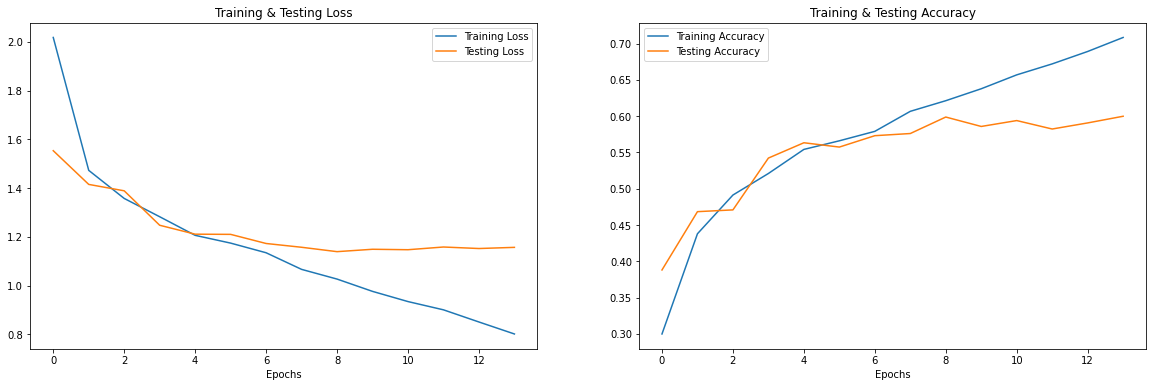

In [102]:
print_report_v3(history, 'categorical_accuracy', 'val_categorical_accuracy')

In [103]:

mu.save_metrics(model, test_basic[0], test_basic[1], encoder)

116/116 [==============================] - 1s 9ms/step


### Predictions

In [104]:
y_pred = model.predict(test_basic[0])
y_pred_decoded = encoder.inverse_transform(y_pred)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_decoded.flatten()
df['Actual Labels'] = test_basic_decoded

116/116 [==============================] - 1s 10ms/step


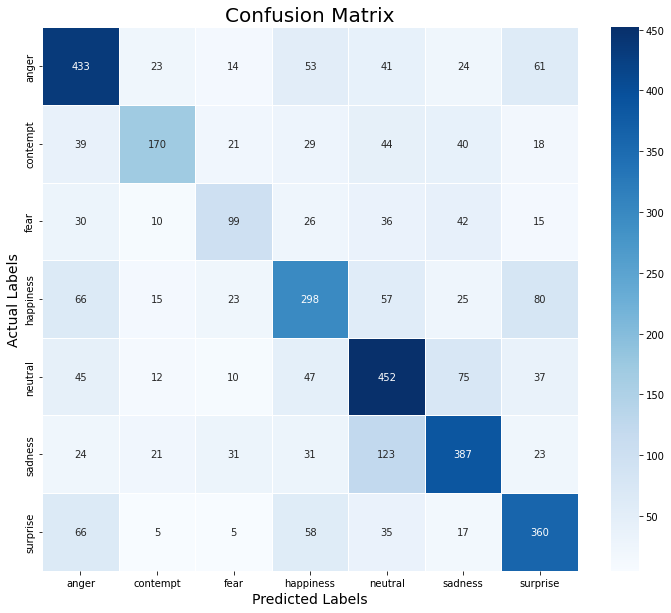

              precision    recall  f1-score   support

       anger       0.62      0.67      0.64       649
    contempt       0.66      0.47      0.55       361
        fear       0.49      0.38      0.43       258
   happiness       0.55      0.53      0.54       564
     neutral       0.57      0.67      0.62       678
     sadness       0.63      0.60      0.62       640
    surprise       0.61      0.66      0.63       546

    accuracy                           0.59      3696
   macro avg       0.59      0.57      0.58      3696
weighted avg       0.60      0.59      0.59      3696



In [105]:
print_confusion_matrix(test_basic_decoded, y_pred_decoded)
print(classification_report(test_basic_decoded, y_pred_decoded))

In [106]:
tmp_model_path = f'{model.name}.keras'


In [107]:
model.save(tmp_model_path)


In [108]:
new_model = tf.keras.models.load_model(tmp_model_path)


In [109]:
np.testing.assert_allclose(
    model.predict(test_basic[0]), new_model.predict(test_basic[0])
)

116/116 [==============================] - 1s 9ms/step


In [110]:
from save_utils import ModelSaver


In [111]:
saver = ModelSaver(new_model, author="Mykola Nosenko", description="Model to predict emotion by audio", license="", version="v2")


In [112]:
model_name

'cnn-gru-v4-seq-no-scale-16khz'

In [113]:
saver.save_tflite(path=f'saved_models/{model_name}.tflite', 
                  labels_path=r'D:\Programming\nn\emotion_classification\ser_diploma\model\encoder_categories.txt', 
                  i_name='mel', i_desc='64x64 melscpectrogram', 
                  o_name='probabitily', o_desc='probability of one of the emotions')

save model cnn-gru-v4-seq-no-scale-16khz to saved_models/cnn-gru-v4-seq-no-scale-16khz.tflite


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmp0uirumsx\assets


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmp0uirumsx\assets


In [51]:
y_pred = new_model.predict(test_basic[0])
y_pred_decoded = encoder.inverse_transform(y_pred)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_decoded.flatten()
df['Actual Labels'] = test_basic_decoded

116/116 [==============================] - 12s 6ms/step


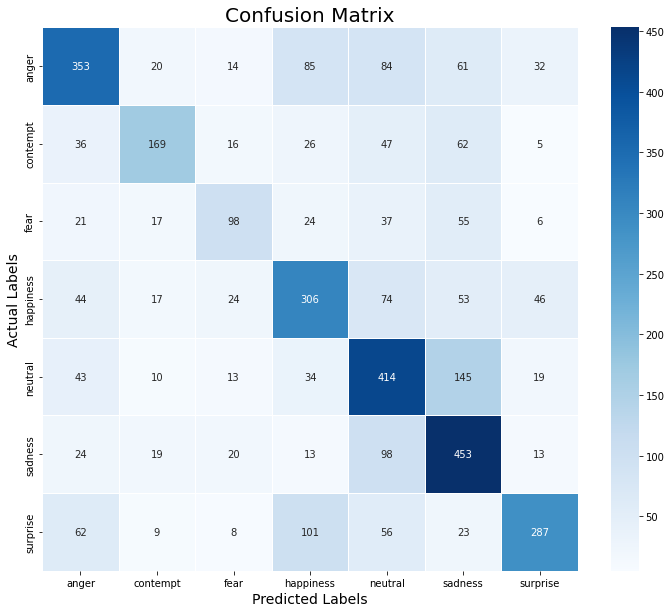

              precision    recall  f1-score   support

       anger       0.61      0.54      0.57       649
    contempt       0.65      0.47      0.54       361
        fear       0.51      0.38      0.43       258
   happiness       0.52      0.54      0.53       564
     neutral       0.51      0.61      0.56       678
     sadness       0.53      0.71      0.61       640
    surprise       0.70      0.53      0.60       546

    accuracy                           0.56      3696
   macro avg       0.58      0.54      0.55      3696
weighted avg       0.57      0.56      0.56      3696



In [52]:
print_confusion_matrix(test_basic_decoded, y_pred_decoded)
print(classification_report(test_basic_decoded, y_pred_decoded))

In [43]:
assert(1 == 2)

AssertionError: 

### k fold

In [16]:
train_fold_data = lu.load_encode_single(train_basic_fold_path, encoder)

./features/features-foldtrain-no-uk-mfcc-v4.csv
(10621, 64, 64) (10621, 7)


In [18]:
def get_model_name(k):
    return 'cnn_res_lstm_1905_v1_checkpoint_fold'+str(k)+'.keras'


def get_callbacks(model_file_path):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_path,
                                                    monitor='val_accuracy', verbose=1,
                                                    save_best_only=True, mode='max')
    
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

    return [checkpoint, early_stopping]

In [19]:
train_size = len(train_basic[0])
batch_size_ = 256
initial_learning_rate = 0.001
final_learning_rate = 0.00001
epochsA = 30
epochsS = 150

learning_rate_decay_factor = (
    final_learning_rate / initial_learning_rate)**(1/epochsA)
steps_per_epoch = int(train_size/batch_size_)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

learning_rate_decay_factor = (0.001 / 0.01)**(1/epochsS)
steps_per_epoch = int(train_size/batch_size_)
lr_schedule_sgd = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

use_sgd = False
if (use_sgd):
    epochs = epochsS
else:
    epochs = epochsA

(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.36846, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 2: val_accuracy improved from 0.36846 to 0.40714, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 3: val_accuracy improved from 0.40714 to 0.41262, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 4: val_accuracy improved from 0.41262 to 0.42092, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 5: val_accuracy did not improve from 0.42092

Epoch 6: val_accuracy did not improve from 0.42092

Epoch 7: val_accuracy did not improve from 0.42092

Epoch 8: val_accuracy did not improve from 0.42092

Epoch 9: val_accuracy did not improve from 0.42092


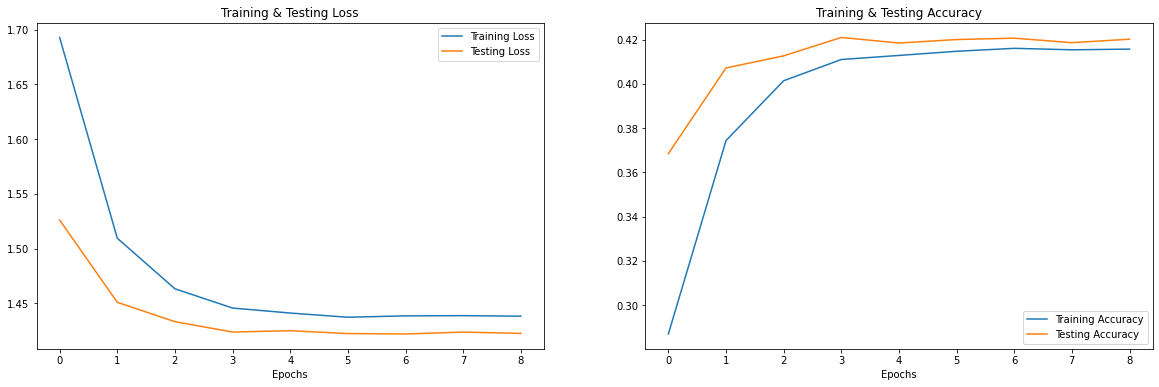

200/200 [==============================] - 3s 14ms/step - loss: 1.4238 - accuracy: 0.4209
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.34581, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 2: val_accuracy improved from 0.34581 to 0.38700, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 3: val_accuracy improved from 0.38700 to 0.39969, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 4: val_accuracy improved from 0.39969 to 0.40940, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 5: val_accuracy improved from 0.40940 to 0.41190, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 6: val_accuracy did not improve from 0.41190

Epoch 7: val_accuracy improved from 0.41190 to 0.41206, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkp

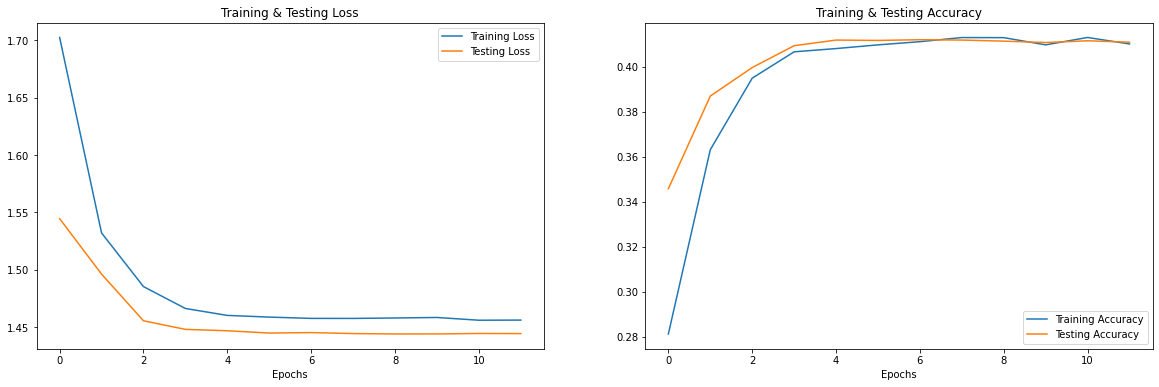

200/200 [==============================] - 2s 9ms/step - loss: 1.4452 - accuracy: 0.4121
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.33187, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 2: val_accuracy improved from 0.33187 to 0.40078, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 3: val_accuracy improved from 0.40078 to 0.40611, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 4: val_accuracy improved from 0.40611 to 0.42396, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 5: val_accuracy did not improve from 0.42396

Epoch 6: val_accuracy did not improve from 0.42396

Epoch 7: val_accuracy did not improve from 0.42396

Epoch 8: val_accuracy did not improve from 0.42396

Epoch 9: val_accuracy did not improve from 0.42396


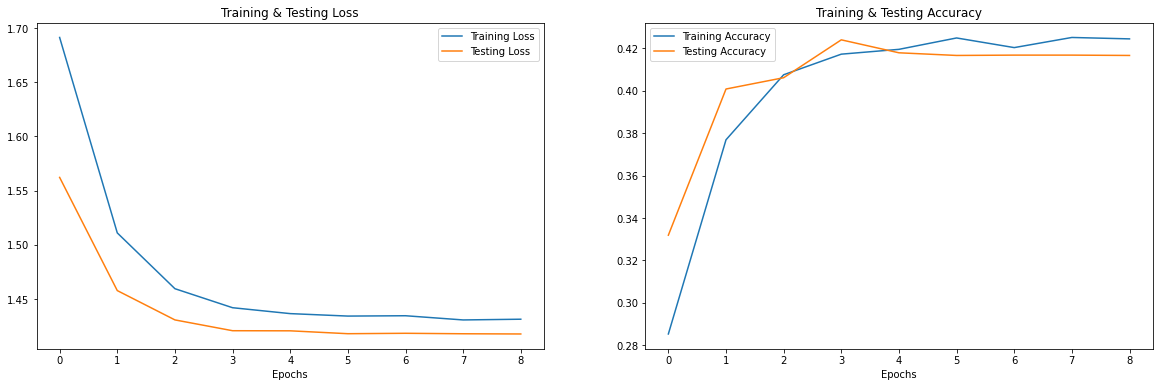

200/200 [==============================] - 2s 9ms/step - loss: 1.4207 - accuracy: 0.4240
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.35756, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 2: val_accuracy improved from 0.35756 to 0.39295, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 3: val_accuracy improved from 0.39295 to 0.41394, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 4: val_accuracy improved from 0.41394 to 0.41629, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 5: val_accuracy improved from 0.41629 to 0.41973, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 6: val_accuracy improved from 0.41973 to 0.42036, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 7: val_accuracy did not impro

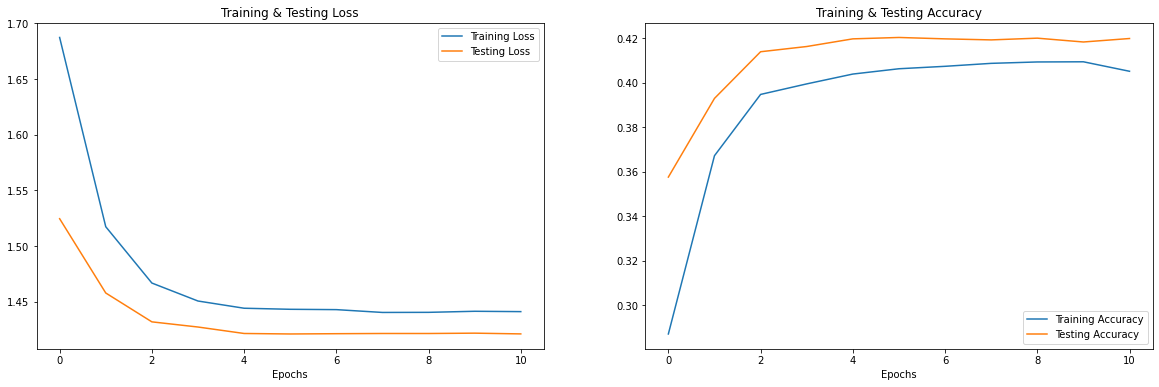

200/200 [==============================] - 2s 8ms/step - loss: 1.4211 - accuracy: 0.4204
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.35787, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 2: val_accuracy improved from 0.35787 to 0.39405, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 3: val_accuracy improved from 0.39405 to 0.41237, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 4: val_accuracy improved from 0.41237 to 0.41519, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 5: val_accuracy improved from 0.41519 to 0.41691, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 6: val_accuracy did not improve from 0.41691

Epoch 7: val_accuracy did not improve from 0.41691

Epoch 8: val_accuracy did not improve from 0.41691

Epoch 9: val_accura

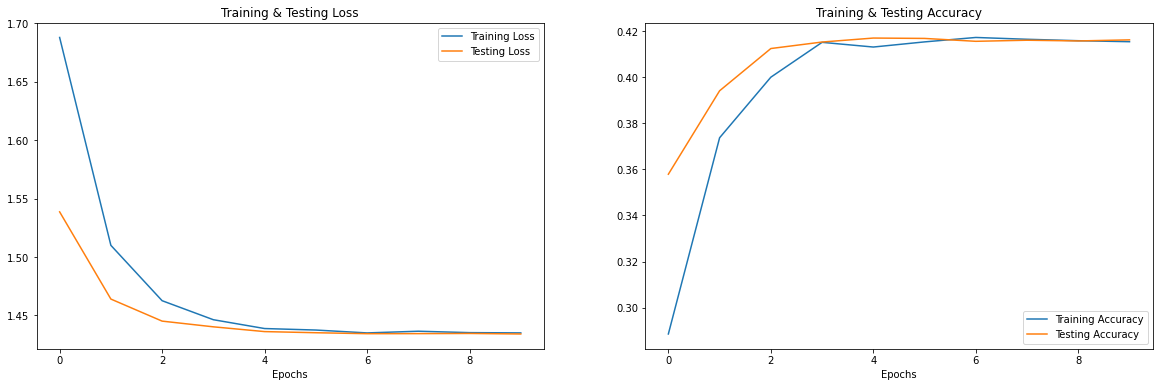

200/200 [==============================] - 3s 16ms/step - loss: 1.4362 - accuracy: 0.4169


In [20]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = 'k_fold/'
fold_var = 1
kfold = KFold(5, shuffle=True, random_state=1)


for train_index, val_index in kfold.split(train_basic[0]):
    training_data = train_basic[0][train_index]
    training_labels = train_basic[1][train_index]
    validation_data = train_basic[0][val_index]
    validation_labels = train_basic[1][val_index]

    # CREATE NEW MODEL
    model = get_model()
    # COMPILE NEW MODEL
    if (use_sgd):
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule_sgd)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # CREATE CALLBACKS
    model_name = save_dir + "final_model_fold" + get_model_name(fold_var)
    callbacks_list = get_callbacks(model_name)


    # FIT THE MODEL
    history = model.fit(training_data, training_labels,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        validation_data=(validation_data, validation_labels), verbose=0)

    # PLOT HISTORY
    print_report_v2(history)

    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(model_name)

    results = model.evaluate(x=validation_data, y=validation_labels)
    results = dict(zip(model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1

In [21]:
VALIDATION_ACCURACY

[0.4209207594394684,
 0.4120595157146454,
 0.42396241426467896,
 0.4203602075576782,
 0.4169146418571472]